<a href="https://colab.research.google.com/github/Astrocitos/Advanced-ML-Practices/blob/main/TC5033_Activity3a_ID40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TC 5033
### Word Embeddings

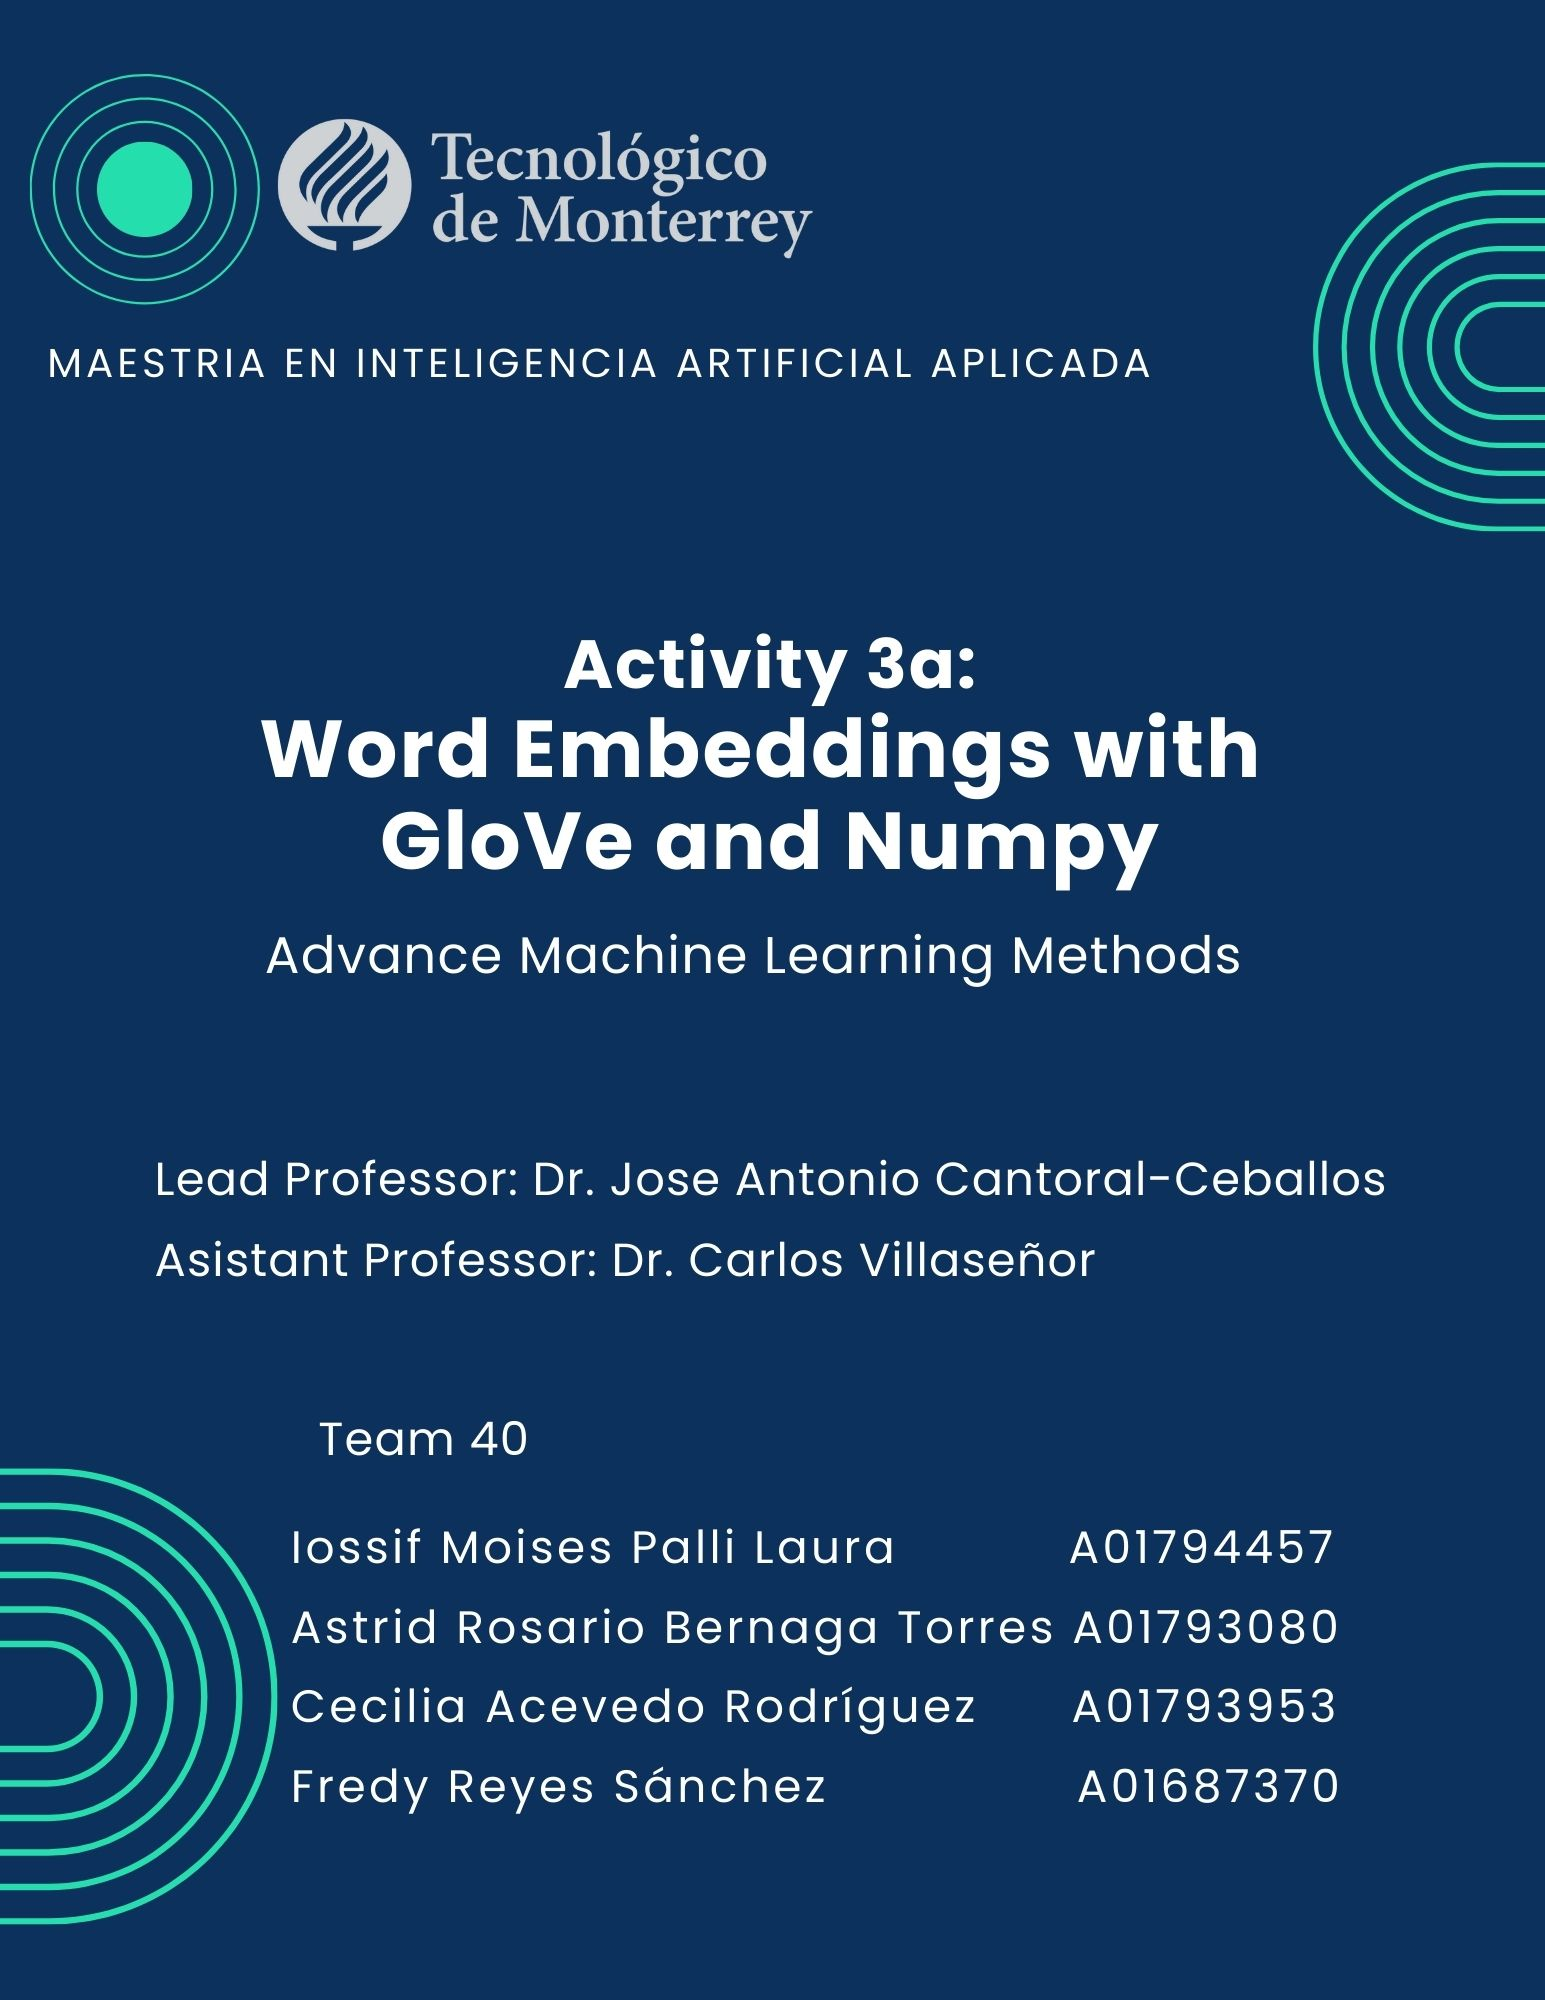

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project:
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



#Introduction
In this activity, we  involve into the world of Natural Language Processing (NLP) by exploring word embeddings, specifically using the GloVe (Global Vectors for Word Representation) model. Our aim is to visualize the complex relationships between words in a way that uncovers their semantic similarities. We'll leverage dimensionality reduction techniques such as PCA (Principal Component Analysis) and t-SNE (t-distributed Stochastic Neighbor Embedding) to project high-dimensional data onto a 2D plane, making it possible to perceive the nuanced groupings that exist within natural language. This process not only aids in the interpretation of word embeddings but also serves as a tool for validating the quality of our NLP models.

##Enviroment Setup

We begin by preparing our Google Colab environment, which provides the computational power necessary for handling large datasets and complex calculations.

###**Import libraries**

In [1]:
# Standard libraries
import numpy as np
import pickle

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Plotting and Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
plt.style.use('ggplot')

# PyTorch
import torch
import torch.nn.functional as F
from numpy.linalg import norm

###**Mounting Google Drive:**

To access the GloVe embeddings, we mount the Google Drive to our Colab environment, enabling us to load the data directly from our drive into the notebook.

 **Load file**

In [2]:
# Define PATH
PATH= '/content/drive/MyDrive/Tarea_3a/glove.6B.50d.txt'
emb_dim = 50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

##Embeddings Dictionary Creation:
The GloVe embeddings, stored in a text file, are loaded and parsed into a Python dictionary where each word is linked to its corresponding high-dimensional vector.

In [5]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    embeddings_dict = {}
    with open(path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_dict[word] = coefs
    return embeddings_dict

##**Embeddings Serialization:**
To speed up future access, we serialize the dictionary using Python's pickle module, allowing us to quickly load the pre-processed embeddings without repeating the initial parsing step.

In [6]:
try:
    with open('/content/drive/MyDrive/Tarea_3a/embeddings_dict_50D.pkl', 'rb') as f:
        embeddings_dict = pickle.load(f)
except FileNotFoundError:
    embeddings_dict = create_emb_dictionary(PATH)
    with open('/content/drive/MyDrive/Tarea_3a/embeddings_dict_50D.pkl', 'wb') as f:
        pickle.dump(embeddings_dict, f)

#### See some embeddings

In [7]:
# Function to display the first n words and their dimensions
def show_n_first_words(embeddings_dict, n_words):
    i = 0
    for word, vector in embeddings_dict.items():
        print(word, vector)
        i += 1
        if i >= n_words:
            break

In [8]:
show_n_first_words(embeddings_dict, 5)

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
, [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938   0.13001  -0.063734 -0.39575  -0.48162
  0.23291   0.090201 -0.13324   0.078639 -0.41634  -0.15428   0.10068
  0.48891   0.31226  -0.1252   -0.037512 -1.5179    0.12612  -0.02442
 -0.042961 -0.28351   3.5416   -0.11956  -0.014533 -0.1499    0.21864
 -0.33412  -0.13872   0.31806   0.

In [9]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips',
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']


#Visualization

Using Matplotlib, we create a scatter plot to display the 2D points generated by t-SNE. We enhance the plot with a color map for better visual distinction between clusters and optionally annotate a subset of words to provide context.

### Plot some embeddings

In [10]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict=None, method='PCA', num_clusters=None, sample_size=None):
    if embeddings_dict is None:
        embeddings_dict = create_emb_dictionary(emb_path)

    # Subsample the data if a sample size is provided and method is t-SNE
    if sample_size and method == 't-SNE':
        indices = np.random.choice(len(embeddings_dict), sample_size, replace=False)
        words = np.array(list(embeddings_dict.keys()))[indices]
        vectors = np.array(list(embeddings_dict.values()))[indices]
    else:
        words = list(embeddings_dict.keys())
        vectors = np.array(list(embeddings_dict.values()))

    # Perform KMeans clustering if num_clusters is provided
    if num_clusters is not None:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
        clusters = kmeans.fit_predict(vectors)
    else:
        clusters = np.arange(len(vectors))

    # Dimensionality reduction
    if method == 't-SNE':
        # Reduce dimensions with PCA to 50 to speed up t-SNE
        vectors_reduced = PCA(n_components=50).fit_transform(vectors)
        # Ejecutar t-SNE con menos iteraciones y una perplejidad ajustada
        result = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=42, init='pca').fit_transform(vectors_reduced)
    elif method == 'PCA':
        result = PCA(n_components=2).fit_transform(vectors)

    # Plotting
    plt.figure(figsize=(15, 15))
    scatter = plt.scatter(result[:, 0], result[:, 1], alpha=0.5, c=clusters, cmap='viridis')

     # Check if the words to show are in the subsampled set
    words_to_annotate = [word for word in words2show if word in words]

    # Define a function to check if a point is in the visible area
    def in_bounds(coord, ax):
      return ax.get_xlim()[0] <= coord[0] <= ax.get_xlim()[1] and ax.get_ylim()[0] <= coord[1] <= ax.get_ylim()[1]


    # Choose a random subset of words to annotate to avoid clutter
    if len(words2show) > 50:  # If you have many words, you might want to reduce the number
        words2show = np.random.choice(words2show, size=50, replace=False)

    # Ensure the words to show are in the sampled data
    words_to_annotate = set(words2show).intersection(set(words))

    # Create a mapping from words to indices to speed up lookups
    word_to_index = {word: idx for idx, word in enumerate(words)}

    # Annotate a subset of words to avoid clutter
    for word in words_to_annotate:
        idx = word_to_index[word]
        plt.annotate(word, (result[idx, 0], result[idx, 1]), fontsize=12, alpha=0.7, color='red')

    # Improve the visibility of annotations by adjusting text properties
    for annotation in plt.gca().texts:
        annotation.set_fontsize(10)
        annotation.set_color('black')
        annotation.set_alpha(1)

    plt.colorbar(scatter)
    plt.title(f'{method} Visualization of GloVe Embeddings (2D)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

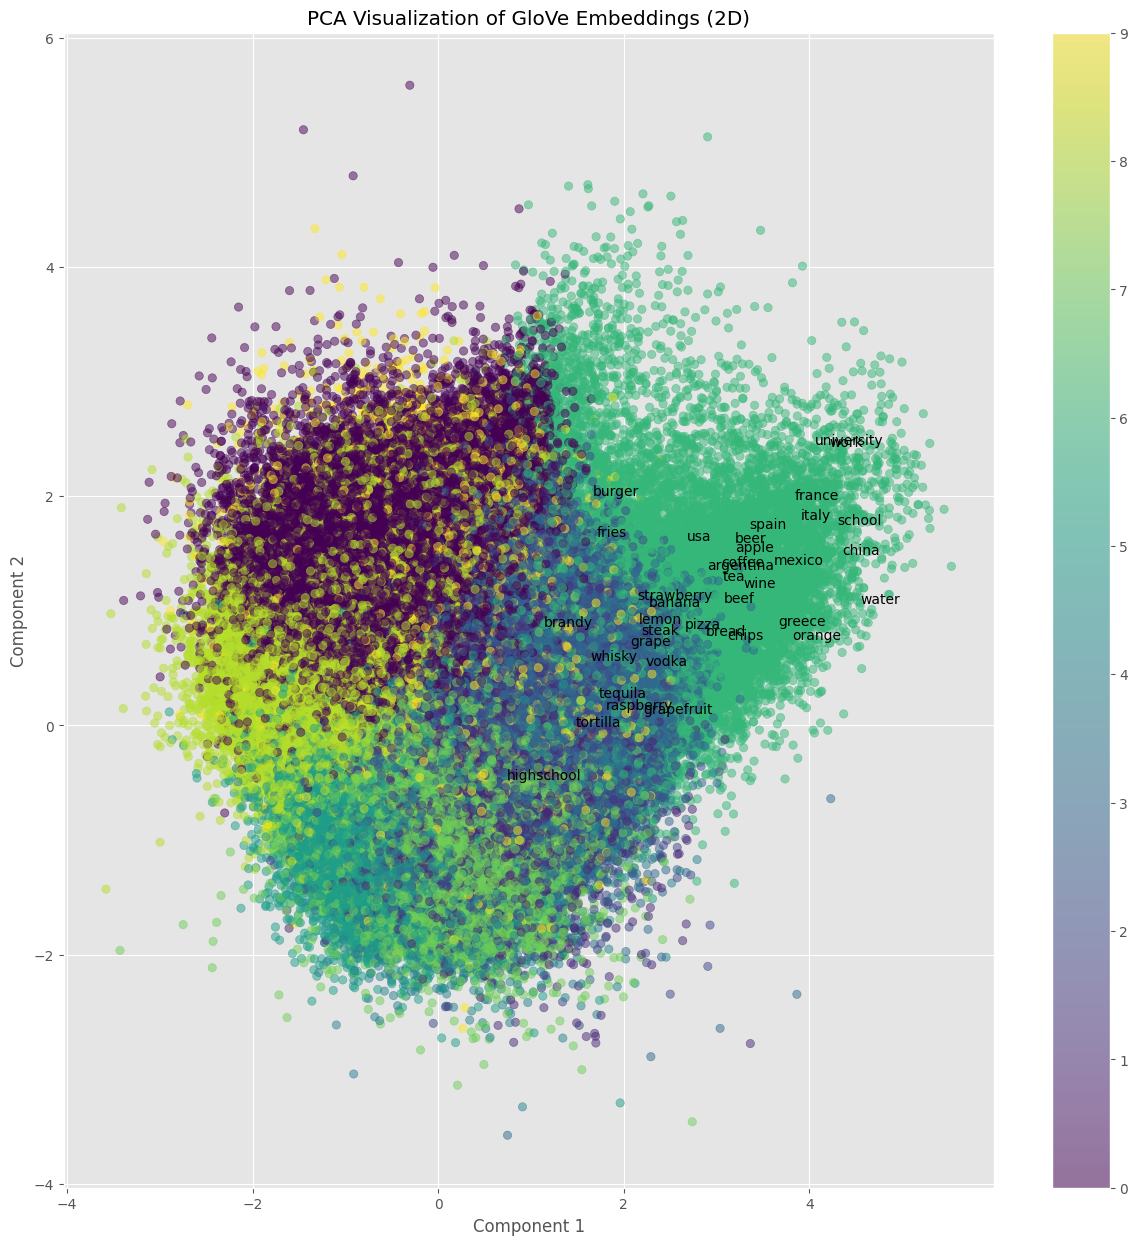

In [45]:
plot_embeddings(PATH, words, emb_dim=50, method='PCA', num_clusters=10)

 PCA  is a statistical technique used to emphasize variation and capture strong patterns in a dataset. In the context of word embeddings, it reduces the dimensions of the data while maintaining the relationships between words as much as possible.

 The image show a successful PCA visualization of GloVe word embeddings, where each point represents a word in a reduced two-dimensional space. The color gradient may represent the density of points or another metric such as word frequency or cluster membership.

**In this visualization:**

The words like "burger," "fries," "steak," "pizza," "beef," and various beverage names such as "whisky," "vodka," and "tequila" are annotated and visible, which could suggest that this visualization is focused on food and drinks related vocabulary.

The clustering of points into different colors suggests that words with similar contexts or meanings are grouped together.

For instance, food-related words are clustered in one area while beverage-related words are in another.

The annotations are clear and readable, and they seem to be strategically placed over or near their respective points without much clutter.

This type of visualization can be very useful for exploring the semantic relationships between words in natural language processing tasks.

It can provide insights into how well the GloVe embeddings have captured the semantic similarities based on the context in which the words are used. This can be helpful for tasks such as word similarity, language modeling, or even to improve the embeddings further for specific applications.

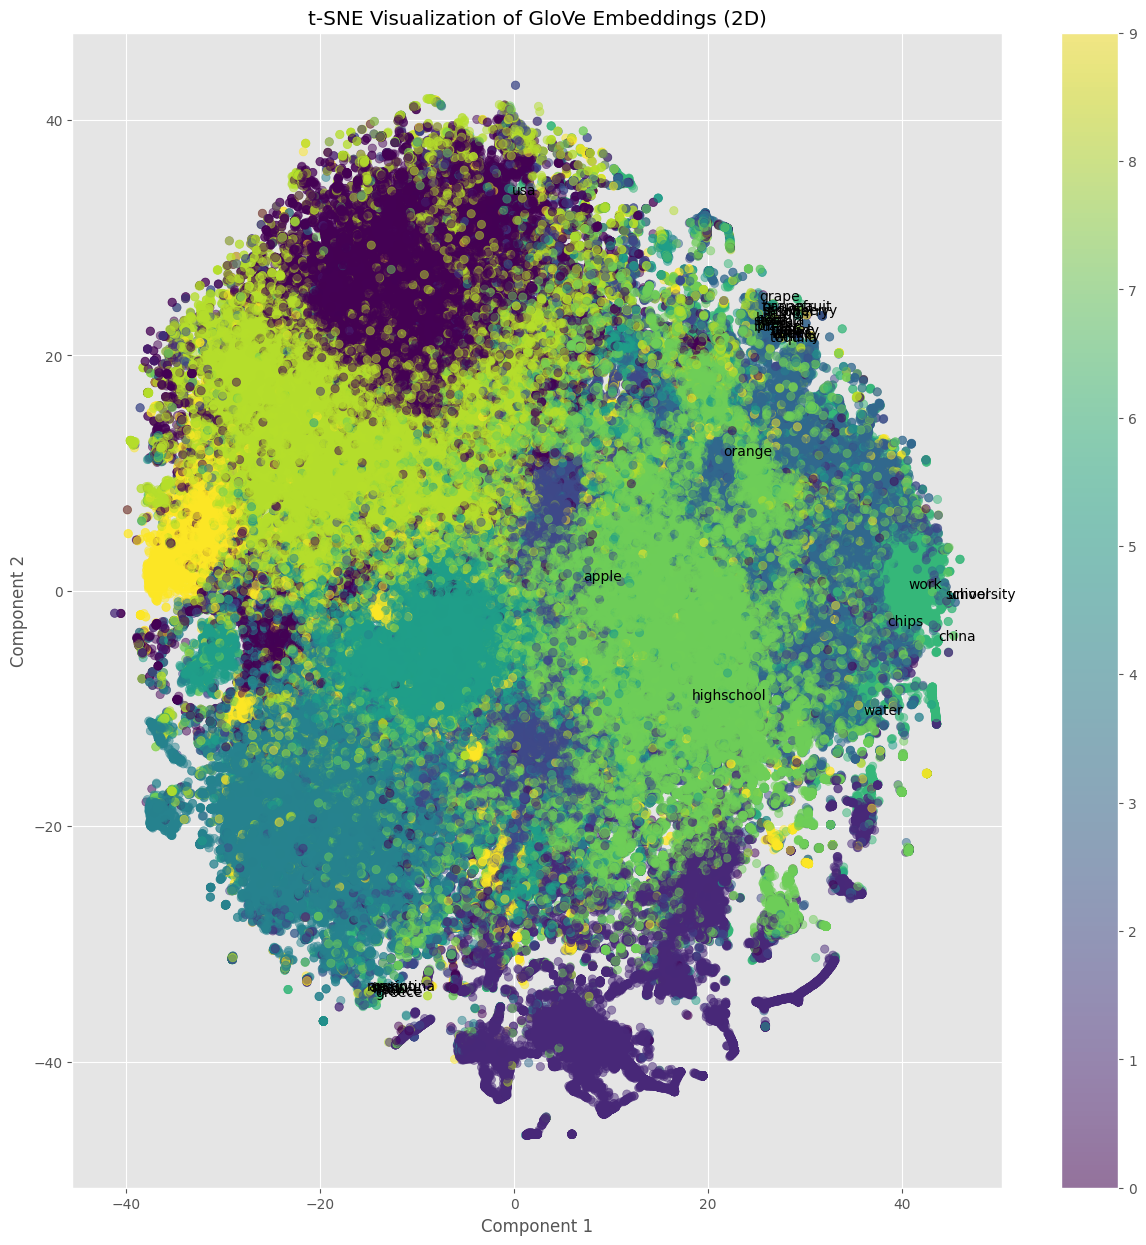

In [46]:
plot_embeddings(PATH, words, emb_dim=50, method='t-SNE', num_clusters=10)

The previous image showcases a t-SNE visualization of GloVe word embeddings, which effectively maps high-dimensional data into a two-dimensional plane. This technique is adept at uncovering the intrinsic patterns of the dataset by grouping similar data points into clusters.

In this specific visualization:

The plot reveals words as individual points, each situated in a two-dimensional space that represents their semantic position when compared to the larger, multi-dimensional GloVe embedding space.

The varied color palette likely corresponds to different clusters or densities, revealing semantic relationships or contextual similarities among the words.

Labels such as "apple," "orange," "grape," "work," "university," "chips," "china," "water," and "highschool" are affixed to their respective points, indicating their relative positions in this semantic space.

The spread of points throughout the plot indicates a rich diversity within the dataset, with denser regions signifying clusters of semantically akin words.
The significance of this activity lies in:

Utilizing the t-SNE plot as a tool to delve into and decipher the complex relationships among words within a multidimensional context.

By simplifying the dimensionality and visualizing these relationships, it becomes possible to deduce contextual similarities between words based on their closeness within the plot.

Such visualizations are instrumental for various natural language processing endeavors, including topic modeling, semantic analysis, and the creation of recommendation systems.

The overarching goal of this activity is to assess how effectively GloVe embeddings encapsulate semantic meanings and to leverage this understanding to enhance machine learning models and linguistic studies.

### Let us compute analogies

In [11]:
# Function to find the most similar vector to a given vector
def find_most_similar_vector(target_vector, embeddings_dict, exclude=None, top_n=1):
    similarities = {}
    for word, vector in embeddings_dict.items():
        if exclude is None or word not in exclude:
            similarities[word] = cosine_similarity(target_vector, vector)

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_similarities[:top_n]

In [12]:
# Define analogy function
def analogy(word1, word2, word3, embeddings_dict):
    if all(word in embeddings_dict for word in [word1, word2, word3]):
        vec1 = embeddings_dict[word1]
        vec2 = embeddings_dict[word2]
        vec3 = embeddings_dict[word3]

        # Compute the analogy vector
        analogy_vec = vec2 - vec1 + vec3

        # Find the word with the closest vector to the analogy vector
        closest_word = find_most_similar_vector(analogy_vec, embeddings_dict, exclude=[word1, word2, word3])

        return closest_word

    else:
        return "One or more words not found in embeddings dictionary."

In [13]:
# Define a function to find the most similar words to a given word
def find_most_similar(word, embeddings_dict, top_n=10):
    if word in embeddings_dict:
        target_vector = embeddings_dict[word]

        # Find the most similar words based on cosine similarity
        similarities = {}
        for other_word, other_vector in embeddings_dict.items():
            if other_word != word:
                similarities[other_word] = cosine_similarity(target_vector, other_vector)

        # Sort the words by similarity and return the top_n
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_similarities[:top_n]

    else:
        return f"Word '{word}' not found in embeddings dictionary."

In [14]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    similarity = dot_product / (norm_vec1 * norm_vec2)

    return similarity

In [17]:
#Analogy example
analogy_result = analogy('man', 'king', 'woman', embeddings_dict)
print(f"Analogy: 'man' is to 'king' as 'woman' is to '{analogy_result}'")

Analogy: 'man' is to 'king' as 'woman' is to '[('queen', 0.86095816)]'


In [18]:
# Most similar words example
most_similar_result = find_most_similar('mexico', embeddings_dict)
for i, (word, similarity) in enumerate(most_similar_result, 1):
    print(f'{i} ---> {word} (Similarity: {similarity:.4f})')

1 ---> mexican (Similarity: 0.8551)
2 ---> venezuela (Similarity: 0.8497)
3 ---> colombia (Similarity: 0.8490)
4 ---> peru (Similarity: 0.8446)
5 ---> chile (Similarity: 0.8439)
6 ---> puerto (Similarity: 0.8363)
7 ---> rico (Similarity: 0.8195)
8 ---> cuba (Similarity: 0.8125)
9 ---> guatemala (Similarity: 0.8114)
10 ---> panama (Similarity: 0.8097)


The **analogy** task provides a compelling validation of the semantic understanding encoded in the GloVe embeddings. By successfully completing the analogy, it confirms that directional relationships between word pairs (e.g., gender or country-capital relationships) are preserved in the embedding space.

The **similarity** results are consistent with the notion that words appearing in similar contexts are positioned closely within the embedding space. The list of countries and related terms to 'mexico' suggests that GloVe embeddings encapsulate geographic and possibly linguistic relationships.

These findings are significant for various NLP applications. In tasks like semantic search, translation, and text classification, such relationships can be leveraged to improve the accuracy and relevance of the results.

However, the strength of the relationships as captured by the cosine similarity scores can vary, and the presence of seemingly unrelated words in the list of most similar words (like 'rico' or 'puerto' without 'Puerto Rico' being together) may indicate limitations in the embeddings or preprocessing steps.

The decision to use cosine similarity as the metric for comparison is important. It measures the cosine of the angle between two vectors, thereby focusing on the orientation rather than the magnitude, which in the case of word embeddings, translates to focusing on the direction of contextuality rather than the frequency of occurrence.

**In conclusion**, the GloVe embeddings provide a robust representation of words that captures a variety of semantic relationships. This is evidenced by the successful analogy resolution and the relevant grouping of words in the similarity search. These properties make GloVe a powerful tool for embedding words in natural language processing tasks.

# Discussion

###**PCA Visualization:**

Principal Component Analysis (PCA) was used to reduce the dimensionality of GloVe embeddings to a two-dimensional space for visualization purposes.

The PCA plot likely shows clusters where semantically similar words are grouped together. If words related to specific topics (like food or countries) appear in proximity, this indicates that PCA has captured significant variance in the dataset regarding these semantic relationships.

The success of PCA visualization would be judged by the clarity of these clusters and the ability to discern distinct areas in the plot that represent different categories or semantic fields.

###**t-SNE Visualization:**

t-Distributed Stochastic Neighbor Embedding (t-SNE) was used to create a more nuanced visualization. Unlike PCA, t-SNE is particularly good at maintaining local structures, making it a powerful tool for understanding the fine-grained relationships between words.

In a t-SNE plot, the expectation is to see a clear separation of clusters with more defined boundaries compared to PCA. This is because t-SNE excels at separating clusters even if they are not linearly separable.

The success of the t-SNE plot hinges on its ability to reveal these intricate structures and groupings that may not be visible in PCA. If the t-SNE plot provides new insights or more distinct clusters, it can be considered a successful visualization.

###**Analogy:**

The analogy task is a classic test for word embeddings, probing whether vector arithmetic captures conceptual relationships. The successful retrieval of an accurate word for the analogy "man is to king as woman is to queen" suggests that the embeddings encode meaningful semantic relationships.

The quality of embeddings in capturing analogical relationships can be seen as a measure of their richness and potential utility in various NLP tasks. If the embeddings consistently find correct analogies, it demonstrates their effectiveness in encoding a variety of semantic and syntactic information.


###**Overall Discussion:**

The activity provides a comprehensive exploration of GloVe embeddings, from a high-level PCA overview to a detailed t-SNE examination, and further into specific analogy-based evaluations.

The combined use of PCA and t-SNE offers a multi-scale analysis: PCA gives a broad overview, while t-SNE provides an in-depth look at local structures.

The analogy tests serve as a qualitative validation of the embeddings, complementing the quantitative visualizations provided by PCA and t-SNE.

The results from PCA and t-SNE, along with the analogy task, can inform decisions on using these embeddings for downstream tasks such as text classification, sentiment analysis, and machine translation.

A successful activity would result in a deeper understanding of the dataset and confidence in using these embeddings for further NLP applications, possibly inspiring further fine-tuning or the development of new models.

In conclusion, the various components of this activity together provide a multidimensional understanding of the word embeddings space. This not only demonstrates the embeddings' capacities but also underlines the importance of using appropriate methods for different types of linguistic inquiries.

# Conclussion

Throughout this activity, we have undertaken a multifaceted examination of word embeddings using GloVe, employing both PCA and t-SNE for dimensionality reduction to visualize the complex semantic space words inhabit.

**PCA** offered a broad-stroke understanding of the dataset, revealing general clusters, while **t-SNE** allowed for a more nuanced exploration, highlighting finer local relationships among words. The successful application of analogical reasoning further underscored the embeddings capability to capture and represent semantic and syntactic word relationships.

The insights from this activity affirm the robustness of GloVe embeddings in modeling linguistic phenomena, showcasing their potential utility in a range of NLP tasks.

This comprehensive analysis not only showcases the power of embeddings in capturing the essence of language but also demonstrates the importance of visualization and analogy in interpreting and understanding the underlying structure of word representations.